<a href="https://colab.research.google.com/github/zchuning/BankruptcyDataAnalysis/blob/master/BankruptcyDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Data Loading



In [3]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scikit-learn
!pip install xgboost
!pip install torch torchvision

In [0]:
# Import modules
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import arff

from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, \
f1_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

## Loading data into collab

1.   Open the file browsing menu by clicking on the tab with a right pointing
arrow.
2.   Navigate to each directories parent until you reach the root.
3.   Upload the .arff file for each year's bankruptcy data. 
4.   Run the code blocks below.



### Partial Dataset

In [0]:
# Load the bankruptcy data of year 5 into pandas dataframe
data, meta = arff.loadarff('/content/5year.arff')
data = np.array(data.tolist(), np.float)

# Extracting X and y
X = data[:, :-1]
y = data[:, -1]

cweight = {0: 1, 1: 15}

### Full Dataset

In [0]:
# Load the full bankruptcy data into pandas dataframes
year1, meta = arff.loadarff('/content/1year.arff')
year1 = np.array(year1.tolist(), np.float)
year2, meta = arff.loadarff('/content/2year.arff')
year2 = np.array(year1.tolist(), np.float)
year3, meta = arff.loadarff('/content/3year.arff')
year3 = np.array(year1.tolist(), np.float)
year4, meta = arff.loadarff('/content/4year.arff')
year4 = np.array(year1.tolist(), np.float)
year5, meta = arff.loadarff('/content/5year.arff')
year5 = np.array(year1.tolist(), np.float)

# Extracting X_full and y_full
X_full = np.vstack((year1[:, :-1], year2[:, :-1], year3[:, :-1], year4[:, :-1], year5[:, :-1]))
y_full = np.hstack((year1[:, -1], year2[:, -1], year3[:, -1], year4[:, -1], year5[:, -1]))

cweight_full = {0: 1, 1: 20}

# Data Processing

## Imputation Functions

In [0]:
# Zero imputation function
def zeroImpute(X_miss):
    return np.nan_to_num(X_miss.copy())

In [0]:
# Regression imputation function
def regressedImpute(X_baseImputed, X_miss):
    X_imputed = X_baseImputed.copy()

    for j in range(X_baseImputed.shape[1]):
        # Build model for current column
        selector = [x for x in range(X_baseImputed.shape[1]) if x != j]
        X_filtered = X_baseImputed[~np.isnan(X_miss[:,j])]
        y_filtered = X_filtered[:,j]
        X_filtered = X_filtered[:, selector]
        col_clf = LinearRegression().fit(X_filtered, y_filtered)

    # Replace X_imputed with new values using new model
    for i in range(X_miss.shape[0]):
        if np.isnan(X_miss[i, j]):
            X_imputed[i, j] =\
            col_clf.predict(X_baseImputed[i, selector].reshape(1, -1))

    return X_imputed

In [0]:
# Epoch regression imputation
def impute(X_miss, epochs=2):
    X_imputed = zeroImpute(X_miss.copy())
    for _ in range(epochs):
        X_imputed = regressedImpute(X_imputed, X_miss)
    return X_imputed

## Creating Training and Test Sets

We assign 70% of the data into the training set and the remaining 30% into the test set.



### Partial dataset

In [0]:
# Impute partial X
X_imputed = impute(X)

# Separate positive and negative samples to balance training and test sets
X_pos = X_imputed[y == 1]
y_pos = y[y == 1]
X_neg = X_imputed[y == 0]
y_neg = y[y == 0]

# Balance data by undersample the majority class
# indices = random.sample(range(1, len(X_neg)-1), 800)
# X_neg = X_neg[indices]
# y_neg = y_neg[indices]

# Split partial data into training and test sets
pos = int(len(y_pos) * 0.7)
neg = int(len(y_neg) * 0.7)

X_train = np.concatenate((X_neg[:neg], X_pos[:pos]))
y_train = np.concatenate((y_neg[:neg], y_pos[:pos]))
X_train, y_train = shuffle(X_train, y_train)

X_test = np.concatenate((X_neg[neg:], X_pos[pos:]))
y_test = np.concatenate((y_neg[neg:], y_pos[pos:]))
X_test, y_test = shuffle(X_test, y_test)

X_train_norm = StandardScaler().fit_transform(X_train)
X_test_norm = StandardScaler().fit_transform(X_test)

### Full dataset

In [0]:
# Impute full X (takes a long time)
X_imputed_full = impute(X_full)
X_full_norm = StandardScaler().fit_transform(X_imputed_full)

# Separate positive and negative samples to balance training and test sets
X_pos_full = X_imputed_full[y_full == 1]
y_pos_full = y_full[y_full == 1]
X_neg_full = X_imputed_full[y_full == 0]
y_neg_full = y_full[y_full == 0]

# Split full data into training and test sets
pos_full = int(len(y_pos_full) * 0.7)
neg_full = int(len(y_neg_full) * 0.7)

X_train_full = np.concatenate((X_neg_full[:neg_full], X_pos_full[:pos_full]))
y_train_full = np.concatenate((y_neg_full[:neg_full], y_pos_full[:pos_full]))
X_train_full, y_train_full = shuffle(X_train_full, y_train_full)
X_train_full_norm = StandardScaler().fit_transform(X_train_full)

X_test_full = np.concatenate((X_neg_full[neg_full:], X_pos_full[pos_full:]))
y_test_full = np.concatenate((y_neg_full[neg_full:], y_pos_full[pos_full:]))
X_test_full, y_test_full = shuffle(X_test_full, y_test_full)
X_test_full_norm = StandardScaler().fit_transform(X_test_full)

#Utility Functions

In [0]:
# Plot training results
def plot_line_graph(x_vals, y_vals_1, y_vals_2, y_vals_3, y_vals_1_label, \
                    y_vals_2_label, y_vals_3_label, x_axis_label, \
                    y_axis_label, title):

    plt.plot(x_vals, y_vals_1, color='g', label=y_vals_1_label)
    plt.plot(x_vals, y_vals_2, color='orange', label=y_vals_2_label)
    plt.plot(x_vals, y_vals_3, color='b', label=y_vals_3_label)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

def get_eval_scores(y_test, y_pred):
    acc_score = accuracy_score(y_test, y_pred)
    pre_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc_score, pre_score, rec_score, f1

# Plot AUC curve
def plot_AUC(y_pred_proba, y_test):
    pos_score = y_pred_proba[:,1]
    fpr, tpr, _ = roc_curve(y_test, pos_score)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Principle Component Analysis

In [0]:
def pca(X, y):
  pca = PCA(n_components = 2)
  principal_components = pca.fit_transform(X)

  selected_rows = (-0.3 < principal_components[:,0]) & (principal_components[:,0]< 0.3 )
  selected_rows = selected_rows & (-0.5 < principal_components[:,1]) & (principal_components[:,1] < 0.5)

  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1)

  ax.scatter(principal_components[selected_rows,0], principal_components[selected_rows,1], c=y[selected_rows], cmap=cm.brg)

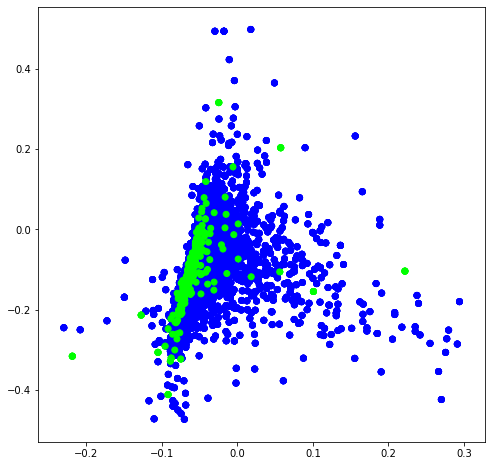

In [39]:
pca(X_full_norm, y_full)

# K Nearest Neighbors

In [0]:
def knn(X_train, y_train, X_test, y_test):
    K = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None
    
    for i in range(len(K)):
        clf = KNeighborsClassifier(n_neighbors=K[i], p=2, weights="distance")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# K: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(K[i]), str(pre_score), str(rec_score), str(f1)))
        
        if (i == len(K) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(K, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', 'K', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)

# K: 1, Precision: 0.2647058823529412, Recall: 0.21951219512195122, F1: 0.24
# K: 3, Precision: 0.42857142857142855, Recall: 0.14634146341463414, F1: 0.2181818181818182
# K: 5, Precision: 0.5862068965517241, Recall: 0.13821138211382114, F1: 0.2236842105263158
# K: 7, Precision: 0.6818181818181818, Recall: 0.12195121951219512, F1: 0.20689655172413793
# K: 9, Precision: 0.6666666666666666, Recall: 0.08130081300813008, F1: 0.14492753623188406
# K: 11, Precision: 0.5454545454545454, Recall: 0.04878048780487805, F1: 0.08955223880597014
# K: 13, Precision: 0.6666666666666666, Recall: 0.04878048780487805, F1: 0.0909090909090909
# K: 15, Precision: 0.8333333333333334, Recall: 0.04065040650406504, F1: 0.07751937984496124
# K: 17, Precision: 0.6666666666666666, Recall: 0.032520325203252036, F1: 0.062015503875969
# K: 19, Precision: 0.75, Recall: 0.04878048780487805, F1: 0.09160305343511452
# K: 21, Precision: 0.7142857142857143, Recall: 0.04065040650406504, F1: 0.07692307692307693
# K: 23, Preci

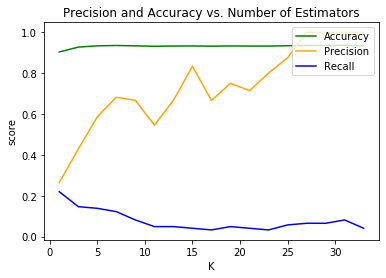

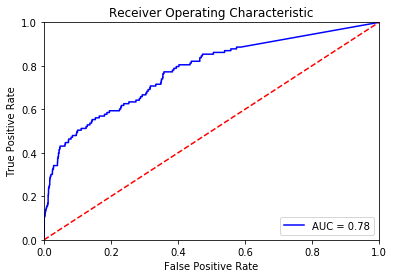

In [23]:
X_train_norm = StandardScaler().fit_transform(X_train)
X_test_norm = StandardScaler().fit_transform(X_test)

knn(X_train_norm, y_train, X_test_norm, y_test)

#Random Forest


In [0]:
def random_forest(X_train, y_train, X_test, y_test, class_weight):
    n_estimators = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None

    for i in range(len(n_estimators)):
        clf = RandomForestClassifier(n_estimators=n_estimators[i], max_depth=6, \
                                     class_weight=class_weight)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# Estimators: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(n_estimators[i]), str(pre_score), str(rec_score), str(f1)))

        if (i == len(n_estimators) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(n_estimators, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', '# Estimators', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)

# Estimators: 5, Precision: 0.37435897435897436, Recall: 0.5934959349593496, F1: 0.4591194968553459
# Estimators: 10, Precision: 0.45454545454545453, Recall: 0.6097560975609756, F1: 0.5208333333333334
# Estimators: 25, Precision: 0.4293785310734463, Recall: 0.6178861788617886, F1: 0.5066666666666667
# Estimators: 50, Precision: 0.4819277108433735, Recall: 0.6504065040650406, F1: 0.5536332179930796
# Estimators: 75, Precision: 0.4491017964071856, Recall: 0.6097560975609756, F1: 0.5172413793103449
# Estimators: 100, Precision: 0.4601226993865031, Recall: 0.6097560975609756, F1: 0.5244755244755245
# Estimators: 125, Precision: 0.47023809523809523, Recall: 0.6422764227642277, F1: 0.5429553264604812
# Estimators: 150, Precision: 0.4578313253012048, Recall: 0.6178861788617886, F1: 0.5259515570934257
# Estimators: 175, Precision: 0.4601226993865031, Recall: 0.6097560975609756, F1: 0.5244755244755245
# Estimators: 200, Precision: 0.4625, Recall: 0.6016260162601627, F1: 0.5229681978798587


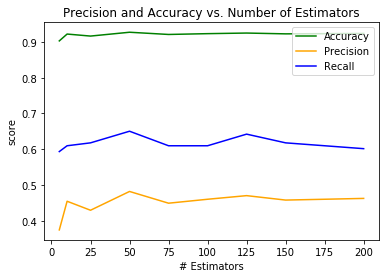

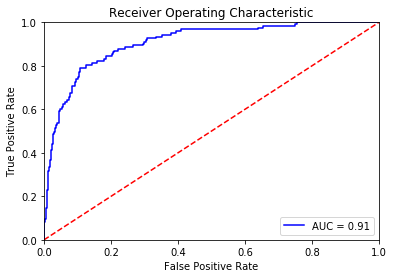

In [0]:
random_forest(X_train, y_train, X_test, y_test, cweight)
# random_forest(X_train_full, y_train_full, X_test_full, y_test_full, cweight_full)

# Logistic Regression

In [0]:
def logistic_regression(X_train, y_train, X_test, y_test, class_weight):
    clf = LogisticRegression(solver='lbfgs', class_weight=class_weight, max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    print('<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>')
    acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
    print('Precision: {0}, Recall: {1}, F1: {2}'.format(str(pre_score), str(rec_score), str(f1)))
    plot_AUC(y_pred_proba, y_test)

<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>
Precision: 0.19037199124726478, Recall: 0.7073170731707317, F1: 0.30000000000000004


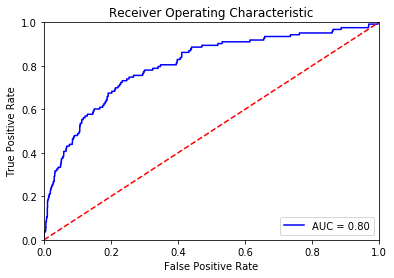

In [25]:
X_train_norm = StandardScaler().fit_transform(X_train)
X_test_norm = StandardScaler().fit_transform(X_test)

logistic_regression(X_train_norm, y_train, X_test_norm, y_test, cweight)

# Support Vector Machine

In [0]:
def svm(X_train, y_train, X_test, y_test, class_weight):
    clf = SVC(gamma='auto', class_weight=class_weight, probability=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    print('<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>')
    acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
    print('Precision: {0}, Recall: {1}, F1: {2}'.format(str(pre_score), str(rec_score), str(f1)))
    plot_AUC(y_pred_proba, y_test)

<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>
Precision: 0.19210526315789472, Recall: 0.5934959349593496, F1: 0.2902584493041749


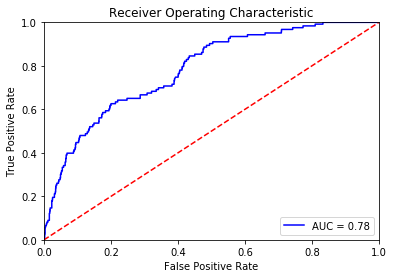

In [28]:
svm(X_train_norm, y_train, X_test_norm, y_test, cweight)

# Boosting

## AdaBoost

In [0]:
def adaboost(X_train, y_train, X_test, y_test):
    n_estimators = [50, 100, 150, 200]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None

    for i in range(len(n_estimators)):
        clf = AdaBoostClassifier(n_estimators=n_estimators[i])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# Estimators: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(n_estimators[i]), str(pre_score), str(rec_score), str(f1)))

        if (i == len(n_estimators) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(n_estimators, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', '# Estimators', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)

# Estimators: 50, Precision: 0.8243243243243243, Recall: 0.4959349593495935, F1: 0.6192893401015229
# Estimators: 100, Precision: 0.868421052631579, Recall: 0.5365853658536586, F1: 0.663316582914573
# Estimators: 150, Precision: 0.7701149425287356, Recall: 0.5447154471544715, F1: 0.638095238095238
# Estimators: 200, Precision: 0.7045454545454546, Recall: 0.5040650406504065, F1: 0.5876777251184835


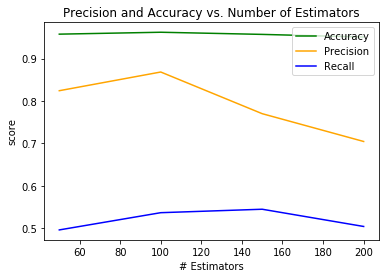

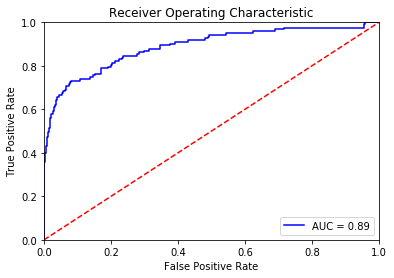

In [0]:
adaboost(X_train, y_train, X_test, y_test)

## Gradient Tree Boosting

In [0]:
def gradient_boosting(X_train, y_train, X_test, y_test):
    n_estimators = [50, 100, 150, 200]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None

    for i in range(len(n_estimators)):
        clf = GradientBoostingClassifier(n_estimators=n_estimators[i])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# Estimators: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(n_estimators[i]), str(pre_score), str(rec_score), str(f1)))

        if (i == len(n_estimators) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(n_estimators, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', '# Estimators', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)

# Estimators: 50, Precision: 0.8591549295774648, Recall: 0.4959349593495935, F1: 0.6288659793814433
# Estimators: 100, Precision: 0.8125, Recall: 0.5284552845528455, F1: 0.6403940886699508
# Estimators: 150, Precision: 0.8024691358024691, Recall: 0.5284552845528455, F1: 0.6372549019607844
# Estimators: 200, Precision: 0.8148148148148148, Recall: 0.5365853658536586, F1: 0.6470588235294118


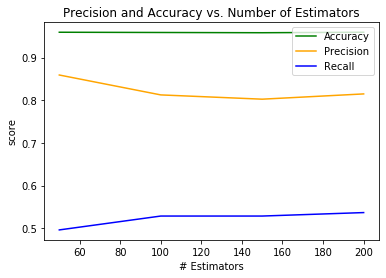

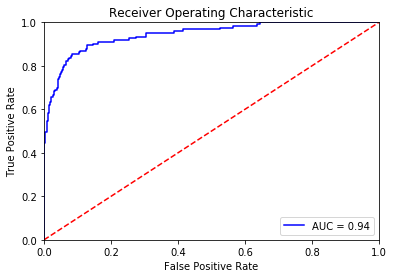

In [0]:
gradient_boosting(X_train, y_train, X_test, y_test)

## Extreme Gradient Boosting

In [0]:
def xgboost(X_train, y_train, X_test, y_test):
    n_estimators = [50, 100, 150, 200]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None

    for i in range(len(n_estimators)):
        clf = XGBClassifier(n_estimators=n_estimators[i])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# Estimators: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(n_estimators[i]), str(pre_score), str(rec_score), str(f1)))

        if (i == len(n_estimators) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(n_estimators, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', '# Estimators', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)


# Estimators: 50, Precision: 0.921875, Recall: 0.4796747967479675, F1: 0.6310160427807486
# Estimators: 100, Precision: 0.8873239436619719, Recall: 0.5121951219512195, F1: 0.6494845360824741
# Estimators: 150, Precision: 0.863013698630137, Recall: 0.5121951219512195, F1: 0.6428571428571429
# Estimators: 200, Precision: 0.8181818181818182, Recall: 0.5121951219512195, F1: 0.63


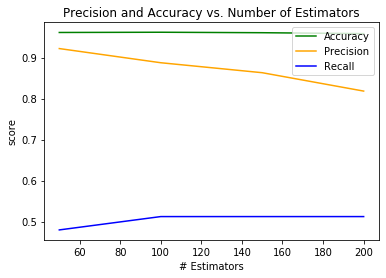

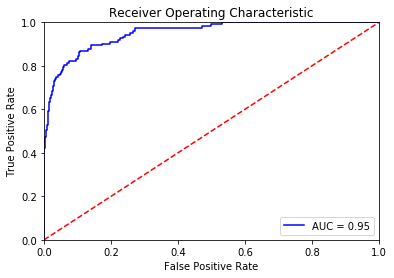

In [0]:
xgboost(X_train, y_train, X_test, y_test)

# Multilayer Perceptron (NN)

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        num_features = 64
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)
    def forward(self, X):
        out = self.fc1(X)
        out = torch.tanh(out)
        out = self.fc2(out)
        out = torch.tanh(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)
        return out
    def predict(self, X):
        out = self.forward(X)
        out = F.softmax(out)
        return out

In [0]:
def train_MLP(num_epochs, X_train, y_train, model, criterion, optimizer):
    loss_curve = []
    X = torch.tensor(X_train)
    y = torch.tensor(y_train).long()
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        output = model(X)
        loss = criterion(output, y[:,1])
        loss_curve.append(loss.item())

        loss.backward()
        optimizer.step()
    return model, loss_curve

In [0]:
def multilayer_perceptron(X_train, y_train, X_test, y_test, class_weight):
    num_epochs = 1000
    model = MLP().double()
    cweights_tensor = torch.tensor(class_weight).double()
    criterion = nn.CrossEntropyLoss(weight=cweights_tensor)
    optimizer = optim.Adam(model.parameters())

    y_train_one_hot = np.vstack((1 - y_train, y_train)).T
    trained_model, loss_curve = train_MLP(num_epochs, X_train, y_train_one_hot,\
                                          model, criterion, optimizer)
    
    # Plot training curve
    epochs = np.arange(num_epochs)
    plt.figure()
    plt.plot(epochs,loss_curve,label='size 2')
    plt.title("Loss vs num Epochs")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Evaluate on test set
    y_pred_proba = trained_model.predict(torch.tensor(X_test)).data.numpy()
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Get evaluation scores
    acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
    print('Precision: {0}, Recall: {1}, F1: {2}, Accuracy: {3}'\
          .format(str(pre_score), str(rec_score), str(f1), str(acc_score)))

    # Plot ROC curve
    plot_AUC(y_pred_proba, y_test)


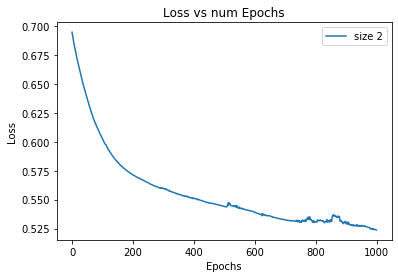

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Precision: 0.18403547671840353, Recall: 0.6747967479674797, F1: 0.28919860627177696, Accuracy: 0.770011273957159


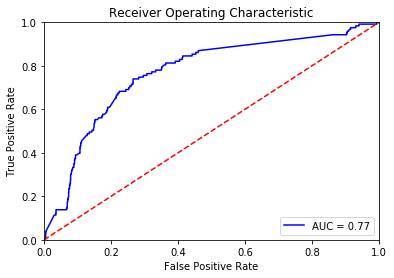

In [0]:
multilayer_perceptron(X_train, y_train, X_test, y_test, [1.0, 15.0])